# Computer Vision 

## Problem Types

* Binary Classification
* Multiclass Classification
* Object Detection
* Image Segmentation

## Architectures
* Convolutional Neural Networks (CNN)
* Transformers


## 0. Preliminaries

In [60]:
# Import PyTorch

import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
#from torchvision import models

# Import DataLoader
from torch.utils.data import DataLoader

# Import torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix

# Import plotting modules
import matplotlib.pyplot as plt
import pandas as pd
import random

# Import timer to see how fast code runs.
from timeit import default_timer as timer
from tqdm.auto import tqdm         # for progress bar

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

# Check versions
print(f"PyTorch Version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")





PyTorch Version: 1.10.2
torchvision version: 0.11.3
mlxtend version: 0.22.0


In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Dataset and Visualize it.

Using FashionMNIST

In [3]:
train_data = datasets.FashionMNIST(
        root = 'data',
        train = True,
        download = True,
        transform = ToTensor(),
        target_transform = None
)

test_data = datasets.FashionMNIST(
        root = 'data',
        train = False,
        download = True,
        transform = ToTensor(),
        target_transform = None
)

In [4]:
# How much training and test data is there?

len(train_data), len(test_data)

(60000, 10000)

In [5]:
# Classes in labels - to convert numbers to text labels
class_names = train_data.classes

img, lbl = train_data[0]

color_chans = img.shape[0]

Image shape: torch.Size([1, 28, 28]) | Label: 9


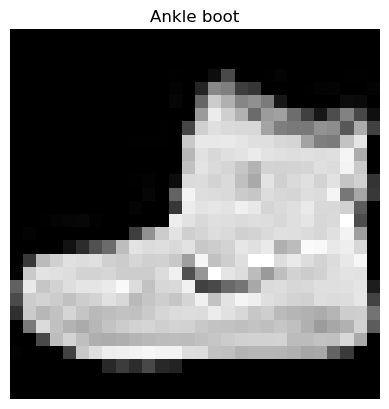

In [6]:
# Visualize first training data point.
if True:
    img, lbl = train_data[0]

    print(f"Image shape: {img.shape} | Label: {lbl}") 

    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[lbl])
    plt.axis(False)
    plt.show()

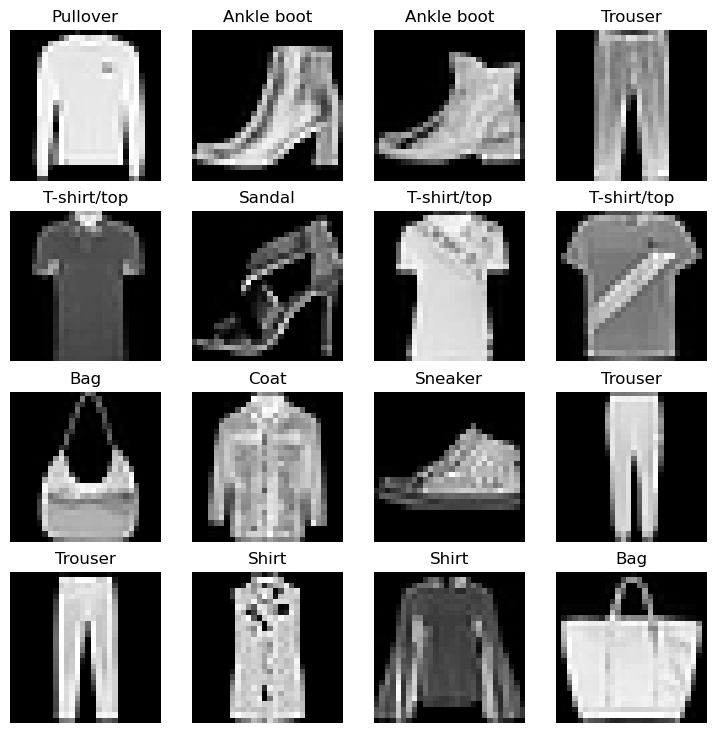

In [7]:
# Plot more images
torch.manual_seed(316)
plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    indx = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[indx]
    plt.subplot(rows, cols, i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[lbl])
    plt.axis(False)
    

## 2. Prepare DataLoader

In [8]:
# Make DataLoader for train and test datasets.

BATCHSIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCHSIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCHSIZE,
                             shuffle = False)

print(f"Training Dataset has {len(train_dataloader)} batches of size {BATCHSIZE}")
print(f"Test Dataset has {len(test_dataloader)} batches of size {BATCHSIZE}")

Training Dataset has 1875 batches of size 32
Test Dataset has 313 batches of size 32


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [10]:
train_features_batch.shape

torch.Size([32, 1, 28, 28])

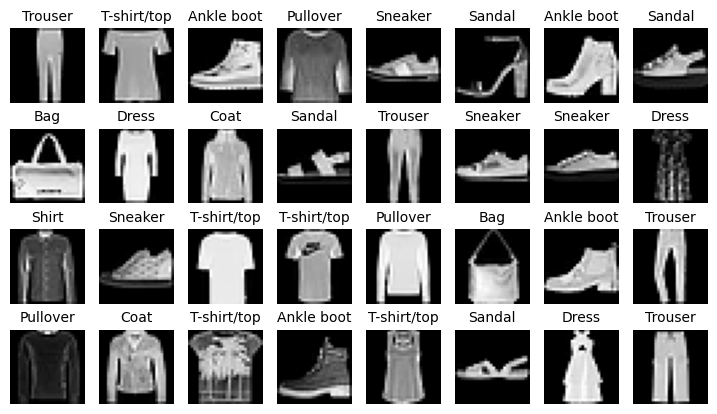

In [11]:
# Show samples in a batch:
torch.manual_seed(316)
plt.figure(figsize=(9,5))
rows, cols = 4, 8
for i in range(0, rows*cols):
    img, lbl = train_features_batch[i], train_labels_batch[i] 
    #print(img.shape, lbl.item())
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(class_names[lbl], fontsize=10)
    plt.axis(False)


## 3. Baseline Linear Model - model_0

### 3a). Build model

In [12]:
# Q: First, what does the Flatten layer do?

x = train_features_batch[0]

print(f"Before flattening, shape: {x.shape}")
flatten_model = nn.Flatten() # simple reshaping model
output = flatten_model(x)    # forward pass
print(f"After flattening, shape: {output.shape}")

Before flattening, shape: torch.Size([1, 28, 28])
After flattening, shape: torch.Size([1, 784])


In [13]:
# Class linear model 0
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int): #torch.Tensor()
        super().__init__()
        #
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [14]:
# Instantiate linear model 0

torch.manual_seed(316)

model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)
                              ).to(device)

In [15]:
# Feed some dummy data to see if shapes make sense.
dummy_x = torch.rand([1,1,28,28])
y = model_0(dummy_x)

In [16]:
y

tensor([[-0.1170, -0.2966, -0.1694, -0.0450, -0.6136, -0.0842,  0.0968, -0.1465,
         -0.0644, -0.0806]], grad_fn=<AddmmBackward0>)

### 3b). Train model

In [17]:
# Setup Loss, Optimizer and Eval metrics.
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(), 
                            lr=0.1)

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)) # import accuracy function from torchmetrics
#from helper_functions import accuracy_fn # Could do this too.

In [18]:
# Function to check how fast model runs.

def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):

    """Print difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds.")
    
    return total_time


In [19]:
st = timer()
x = torch.rand(size=(1000,1000))
nd = timer()
print_train_time(st,nd,device=device)

Train time on cpu: 0.005 seconds.


0.0045194170000000256

In [20]:
type(accuracy_fn)

torchmetrics.classification.accuracy.MulticlassAccuracy

In [21]:
# Defining training step

def train_step(model: nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer, 
               loss_fn: nn.Module, 
               accuracy_fn,
               device: torch.device = device):
    
    """ 
    Training step to train a model.
    
    args:
        model       - 
        dataloader  - 
        optimizer   - 
        loss_fn     - 
        accuracy_fn -  
        device      - 
        
        
    returns:
        train_loss - 
        train_acc  - 
    """
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    # Loop through batches
    for batch, (X,y_labels) in enumerate(dataloader):
        
        # Put data on target device
        X, y_labels = X.to(device), y_labels.to(device)
        
        # Forward pass
        y_logits = model(X)
        
        # calculate loss
        loss = loss_fn(y_logits,y_labels)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute accuracy
        y_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_probs, dim=1)
        acc = accuracy_fn(y_preds, y_labels)
        train_acc +=  acc
            
    # Get average loss, acc per batch.
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    # Print whats happening
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.4f}")
    
    return train_loss, train_acc

In [22]:
# Define test step

def test_step(model: nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: nn.Module, 
              accuracy_fn,
              device: torch.device = device):
    
    """
    Compute loss and accuracy on test data without updating model params.
    
    args:
        model       - 
        dataloader  - 
        loss_fn     -
        accuracy_fn - 
        device      -
    
    return:
        test_loss - 
        test_acc  - 
    """
    
    test_loss, test_acc = 0, 0
    
    # Put model in eval mode
    model.eval()

    
    # Put on inference mode context manager
    with torch.inference_mode():
        for batch, (X,y_labels) in enumerate(dataloader):
            
            # Put data on device
            X, y_labels = X.to(device), y_labels.to(device)
            
            # Forward pass
            y_logits = model(X)
            
            # Compute loss
            loss = loss_fn(y_logits, y_labels)
            test_loss += loss
            
            # compute accuracy
            y_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)
            acc = accuracy_fn(y_preds, y_labels)
            test_acc +=  acc
                
        # Get average loss, acc per batch.
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        
    # Print whats happening
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.4f}")
        
    return test_loss, test_acc

In [23]:
# Write training Loop

torch.manual_seed(316)
time_st = timer()
epochs = 3

# Loop through epochs
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n -----")
    
    # train_loss, train_acc = train_step(model_0, train_data_loader, loss_fn, optimizer)
    
    model_0.train()
    
    train_loss, train_acc = 0, 0
    
    # Loop through batches
    for batch, (X,y_labels) in enumerate(train_dataloader):
        
        # Forward pass
        y_logits = model_0(X)
        
        # calculate loss
        loss = loss_fn(y_logits,y_labels)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute accuracy
        y_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_probs, dim=1)
        acc = accuracy_fn(y_preds, y_labels)
        train_acc +=  acc
        
        if False: #batch % 400 == 0:
            print(f"Train Batch: {batch} | loss: {loss:.5f} | acc: {acc:.3f}")
            
    # Get average loss, acc per batch.
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
        
    #print(f"Train Epoch: {epoch} | loss: {train_loss:.5f} | acc: {train_acc:.3f}")
        
    
    # # Calculate Test Loss on every epoch.
    test_loss, test_acc = 0, 0
    
    model_0.eval()
    
    with torch.inference_mode():
        for batch, (X_test,y_test_labels) in enumerate(test_dataloader):
            y_logits = model_0(X_test)
            
            loss = loss_fn(y_logits, y_test_labels)
            test_loss += loss
            
            # compute accuracy
            y_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)
            acc = accuracy_fn(y_preds, y_test_labels)
            test_acc +=  acc
            
            if False: #batch % 100 == 0:
                print(f"Test Batch: {batch} | loss: {loss:.5f} | acc: {acc:.3f}")
                
        # Get average loss, acc per batch.
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
                
    print(f"train loss: {train_loss:.5f} | train acc: {train_acc*100:.3f}% | test loss: {test_loss:.5f} | test acc: {test_acc*100:.3f}%")
   
            
# Print train time        
time_fin = timer()

model0_train_time = print_train_time(time_st,time_fin,device);

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 -----


Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



train loss: 0.58680 | train acc: 79.543% | test loss: 0.51781 | test acc: 81.370%
Epoch: 1 
 -----
train loss: 0.47564 | train acc: 83.313% | test loss: 0.51384 | test acc: 81.889%
Epoch: 2 
 -----
train loss: 0.45468 | train acc: 84.038% | test loss: 0.48859 | test acc: 82.967%
Train time on cpu: 11.166 seconds.


### 3c). Make predictions and evaluate model

In [24]:
torch.manual_seed(316) 

def eval_model(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    """Returns dictionary containing results of model predicting on data_loader"""
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y_labels in dataloader:
            
            # Put data on device (device agnostic code)
            X, y_labels =  X.to(device), y_labels.to(device)
            
            # Make predictions
            y_logits = model(X)
            
            # Accumulate loss and accuracy per batch
            loss += loss_fn(y_logits, y_labels)
            acc += accuracy_fn(  y_logits.argmax(dim=1) , y_labels)
            
        # Divide loss and accuracy by number of batches to get average per batch.
        loss /= len(dataloader)
        acc /= len(dataloader)
                   
        return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc.item() }

In [25]:
model0_results = eval_model(model=model_0,
                            dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

In [26]:
model0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.48858842253685,
 'model_acc': 0.8296725153923035}

## 4. Build better model with non-linearity - model_1

In [27]:
# Model 1: Has two linear layers and a non-linear activation after each one.

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_dims:int,
                 hidden_dims:int,
                 output_dims:int,
                 nonlin_type:str):
        
        super().__init__()
        
        # Define nonlinear activation function. Can add more.
        if nonlin_type=='relu':
            activation = nn.ReLU()
        elif nonlin_type=='sigmoid':
            activation = nn.Sigmoid()
        elif nonlin_type=='tanh':
            activation = nn.Tanh()
        else:
            print(f"Dont understand nonlinearity of type {nonlin_type}. Making Linear network.")
            activation = nn.Identity()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dims,
                      out_features=hidden_dims),
            activation,
            nn.Linear(in_features=hidden_dims,
                      out_features=output_dims),
            activation
        )
        
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [28]:
# Instantiate model_1

torch.manual_seed(316)

model_1 = FashionMNISTModelV1(input_dims=28*28,
                             hidden_dims=50,
                             output_dims=len(class_names),
                             nonlin_type='relu').to(device)

In [29]:
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [30]:
# Feed some dummy data to see if shapes make sense.
dummy_x = torch.rand([1,1,28,28])
y = model_1(dummy_x)

In [31]:
y

tensor([[0.0000, 0.0000, 0.2355, 0.0279, 0.1171, 0.0000, 0.0840, 0.0000, 0.0000,
         0.0000]], grad_fn=<ReluBackward0>)

### 4b. Create loss, optimizer and accuracy metric.

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)
accuracy_fn = Accuracy(task="multiclass",num_classes=len(class_names))

In [33]:
train_dataloader.batch_size

32

### 4c. Train model

In [34]:
torch.manual_seed(316)

time_st = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
     
    print(f"\n Epoch: {epoch} \n --------")
    train_loss, train_acc = train_step(model=model_1, 
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
    
    
    test_loss, test_acc = test_step(model=model_1, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    
time_fin = timer()
model1_train_time = print_train_time(time_st,time_fin,device);

  0%|          | 0/3 [00:00<?, ?it/s]


 Epoch: 0 
 --------
Train loss: 0.90512 | Train accuracy: 0.6906
Test loss: 0.70898 | Test accuracy: 0.7368

 Epoch: 1 
 --------
Train loss: 0.45504 | Train accuracy: 0.8361
Test loss: 0.47491 | Test accuracy: 0.8325

 Epoch: 2 
 --------
Train loss: 0.38721 | Train accuracy: 0.8597
Test loss: 0.39871 | Test accuracy: 0.8575
Train time on cpu: 12.931 seconds.


## Compare model_1 results to model_0 results

In [35]:
model0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.48858842253685,
 'model_acc': 0.8296725153923035}

In [36]:
model1_results =  eval_model(model=model_1,
                     dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn)

In [37]:
model1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.39870500564575195,
 'model_acc': 0.8575279712677002}

# 5. Model 2 - Convolutional Neural Network

In [38]:
# Class Model 2: CNN
class FashionMNISTModelV2(nn.Module):
    """
    Replicate TinyVGG from CNN Explainer website.
    https://poloclub.github.io/cnn-explainer/
    """
    
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        #
        super().__init__()
        #
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #
        self.classifier_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self,x,v=False):
         
        x = self.conv_block1(x)
        if v: print(f"After conv_block1, shape is: {x.shape}") 
        x = self.conv_block2(x)
        if v: print(f"After conv_block2, shape is: {x.shape}") 
        x = self.classifier_block(x)
        if v: print(f"After classifier_block, shape is: {x.shape}")
        
        return x
        

In [39]:
# Instantiate model 2
model_2 = FashionMNISTModelV2(input_shape=color_chans, # 1 color channel because B&W images
                              hidden_units=10,
                              output_shape=len(class_names)
                             ).to(device)

In [40]:
# How to access some of the internal layers of the model to plot and visualize them.

print(f" A nice simple overview of blocks and modules with hyperparameters: \n \n {model_2}")

#print(f"A deeper look into the weights in each layer: \n \n {model_2.state_dict()}")

#for name, param in model_2.conv_block1.named_parameters():
#    print(name, param)

 A nice simple overview of blocks and modules with hyperparameters: 
 
 FashionMNISTModelV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


### 5.1 - Push dummy data through various layers in model_2 (Conv2d)

In [41]:
# Run a dummy input through some layers in model_2 to get a handle on sizes and shapes
torch.manual_seed(316)
X_dummy = torch.rand(size=(32,3,64,64)) # {N, C, H, W}

X_test = X_dummy[0]

X_dummy.shape, X_test.shape

(torch.Size([32, 3, 64, 64]), torch.Size([3, 64, 64]))

In [42]:
# Create single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=0)

In [43]:
y_dummy = conv_layer(X_dummy)
# OR
y_test = conv_layer(X_test.unsqueeze(0))

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [44]:
y_dummy.shape, y_test.shape

(torch.Size([32, 10, 62, 62]), torch.Size([1, 10, 62, 62]))

### 5.2 - Push dummy data through various layers in model_2 (MaxPool)

In [45]:
# Create single MaxPool2d layer
maxpool_layer = nn.MaxPool2d(kernel_size=2)

In [46]:
y_dummy = maxpool_layer(X_dummy)
# OR
y_test = maxpool_layer(X_test.unsqueeze(0))

In [47]:
y_dummy.shape, y_test.shape

(torch.Size([32, 3, 32, 32]), torch.Size([1, 3, 32, 32]))

### 5.3 - Push dummy data through various layers in model_2 (Conv +MaxPool)

In [48]:
print(f"Input Img: {X_test.unsqueeze(0).shape}")
y1_test = conv_layer(X_test.unsqueeze(0))
print(f"After Conv: {y1_test.shape}")
y2_test = maxpool_layer(y1_test)
print(f"After MaxPool: {y2_test.shape}")

Input Img: torch.Size([1, 3, 64, 64])
After Conv: torch.Size([1, 10, 62, 62])
After MaxPool: torch.Size([1, 10, 31, 31])


### 5.4 - Push an image through untrained full model_2

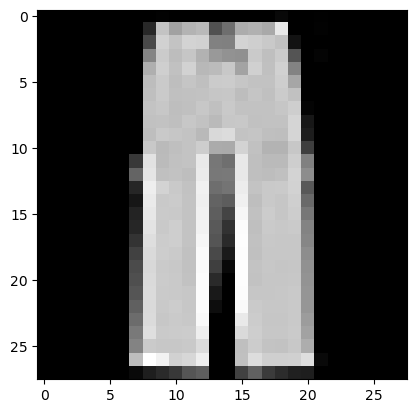

In [49]:
plt.imshow(img.squeeze(), cmap='gray')

In [50]:
model_2(img.unsqueeze(0),v=True)

After conv_block1, shape is: torch.Size([1, 10, 14, 14])
After conv_block2, shape is: torch.Size([1, 10, 7, 7])
After classifier_block, shape is: torch.Size([1, 10])


tensor([[-0.0085,  0.0567,  0.0124, -0.0283, -0.0251, -0.0187,  0.0199,  0.0137,
          0.0509, -0.0325]], grad_fn=<AddmmBackward0>)

### 5.5 Train model_2 - CNN - on DataLoader data

In [51]:
# a). Define Loss, Optimizer & Accuracy
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

accuracy_fn = Accuracy(task='multiclass',num_classes=len(class_names))


In [52]:
# b). Loop through data and do training and test steps.

epochs = 3

time_start = timer()

for epoch in tqdm(range(epochs)):
    
    print(f"Epoch: {epoch} \n --------")
    
    train_step(model=model_2,
               dataloader=train_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_2,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
time_end = timer()

model2_train_time = print_train_time(time_start, time_end, device)

model2_results = eval_model(model=model_2,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 --------
Train loss: 0.73352 | Train accuracy: 0.7304
Test loss: 0.41561 | Test accuracy: 0.8425
Epoch: 1 
 --------
Train loss: 0.37189 | Train accuracy: 0.8656
Test loss: 0.32801 | Test accuracy: 0.8817
Epoch: 2 
 --------
Train loss: 0.33623 | Train accuracy: 0.8783
Test loss: 0.30618 | Test accuracy: 0.8881
Train time on cpu: 157.286 seconds.


## Compare Results across Models

In [53]:
# Pack model results into a dataframe.
compare_results = pd.DataFrame([model0_results,model1_results,model2_results])

# Add training_time to compare_results DataFrame
compare_results['training_time'] = [model0_train_time, model1_train_time, model2_train_time]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.488588,0.829673,11.165562
1,FashionMNISTModelV1,0.398705,0.857528,12.931435
2,FashionMNISTModelV2,0.306182,0.888133,157.285912


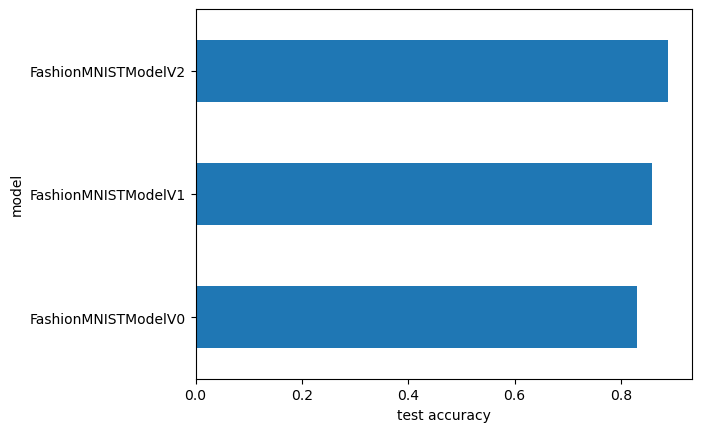

In [54]:
# Plot results comparison

compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("test accuracy")
plt.ylabel('model');

# 6. Model Evaluation: using model_2

 ## 6a. Perform inference on test images
 
 Make predictions on some random samples from test dataset. Plot them along with model prediction colored green if correct and red if incorrect.

In [55]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    """ 
        Function to output list of prediction probability tensors, one for each sample in data. 
        Predictions made by model.
        
        args:
            model
            data
            device
            
        returns:
            pred_probs
    """
    
    pred_probs = []
    
    model.eval()
    with torch.inference_mode():
    
        for img in data:
            
            # Forward pass, model outputs raw logits
            y_logit = model(img.unsqueeze(0))
            
            # Convert logits -> prediction probabilities
            y_prob = y_logit.softmax(dim=1)
            
            pred_probs.append(y_prob)
            
    return pred_probs 

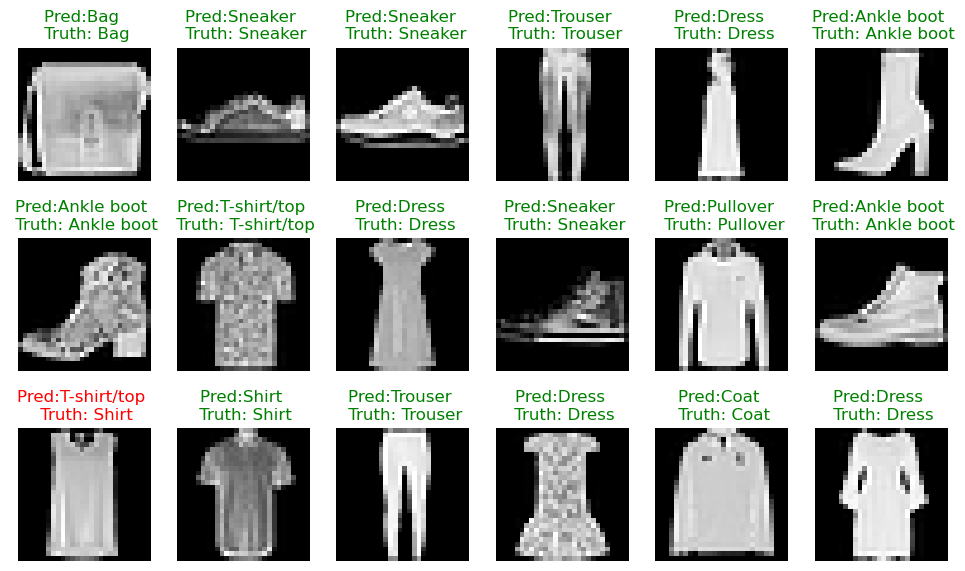

In [56]:
# Take random samples from test_data, make predictions, plot results.
rows=3
cols=6
num_samples=rows*cols

#random.seed(316)

image_samples = []
label_samples = []

for img,lbl in random.sample(list(test_data),k=num_samples):
    image_samples.append(img)
    label_samples.append(lbl)
    
#print(len(image_samples),image_samples[0].shape)

# Make predictions from image_samples
pred_probs = make_predictions(model=model_2,
                              data=image_samples,
                              device=device)


# Plot predictions in a grid
plt.figure(figsize=(12,7))

for i, img in enumerate(image_samples):

    plt.subplot(rows, cols, i+1)
    plt.imshow(img.squeeze(),cmap='gray')

    y_inf = model_2(img.unsqueeze(0))
    if y_inf.argmax().item()==label_samples[i]:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Pred:{class_names[y_inf.argmax().item()]} \n Truth: {class_names[label_samples[i]]}",color=title_color)
    plt.axis(False);



### 6b. Make Confusion Matrix for inference on Test Data

In [57]:
# Make predictions across whole test_data set.

y_preds = []

model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        
        # 1. Send data to device
        X, y = X.to(device), y.to(device)
        
        # 2. Forward pass
        y_logit = model_2(X)
        
        # 3. Convert logit -> probability -> prediction.
        y_prob = y_logit.softmax(dim=1)
        y_pred = y_prob.argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        
    y_preds_tensor = torch.cat(y_preds)


  0%|          | 0/313 [00:00<?, ?it/s]

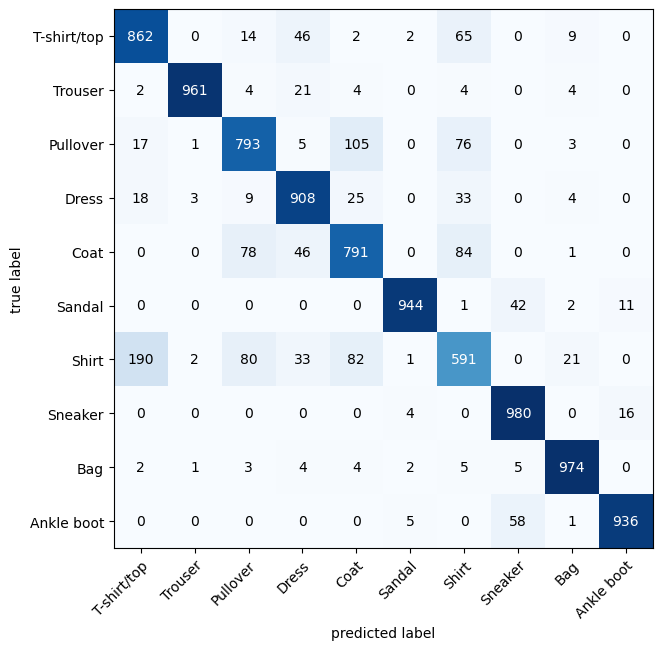

In [70]:
# Plot confusion matrix using mlxtend and torchmetrics

confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds_tensor, 
                         target=test_data.targets)

fig,ax = plot_confusion_matrix(
            conf_mat = confmat_tensor.numpy(),
            class_names=class_names,
            figsize=(10,7)
         )

torch.Size([10000])